# Tiling experiments
This paperwork will analyze data obtained from tiling experiments to compare 4 features of 4 different algorithms' implementations.

The features or variables to measure are the following:
- Algorithm speed up
- Cache misses
- Total of instructions executed
- Cores rate usage

The 4 algorithms selected for the experiment were:
- Matrix multiplication
- Vector multiplication
- Jacobi Example
- ? (still in process)

For each algorithm will have 4 versions
- Original implementation.
- Tiled and handed parallelized algorithm from a benchmark.
- Tiled and parallelized algorithm using Cetus.
- Tiled, parallelized and loop interchange applied algorithm using Cetus.

## Methodology

The proposed methodology is, we will have 4 different versions for each algorithm and will measure the features above for each of them. After that, we are going to use the data obtained to see if tiling improves the algorithms' performance.

For each measurement the independent variable will be the amount ofcores to use for each experiment instance.

## Data creation
For obtaining/creating the data, we will use a group of tools to obtain data in runtime. Those tools are the following:
- PAPI: To access hardware counters and to measure: Cache misses and total of instructions executed
- OMP directives: To measure elapsed time for an algorithm execution and to measure speed up and cores rate usage.

## Experiment results

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./experiments/results1.csv", names=['algorithm','version', 'cores', 'experiment', 'N','M','value'])
df

,algorithm,version,cores,experiment,N,M,value
0,matrix-mult,parallel-paw-single-tiled,1,cache-misses,1200,1200,2.211840e+07
1,matrix-mult,parallel-non-tiled,1,cache-misses,1200,1200,6.755522e+07
2,matrix-mult,parallel-paw-tiled,1,cache-misses,1200,1200,4.735159e+07
3,vector-mult,parallel-paw-single-tiled,1,cache-misses,1200,1200,1.929240e+05
4,vector-mult,parallel-non-tiled,1,cache-misses,1200,1200,1.439040e+05
...,...,...,...,...,...,...,...
211,vector-mult,parallel-non-tiled,8,speed-up,1200,1200,9.850000e-04
212,vector-mult,parallel-paw-tiled,8,speed-up,1200,1200,9.970000e-04
213,jacobi,parallel-paw-single-tiled,8,speed-up,1200,1200,5.378000e-03
214,jacobi,parallel-non-tiled,8,speed-up,1200,1200,3.105000e-03


In [3]:
def filter_by_experiment(algorithm, experiment)->pd.DataFrame:
    filteredAlgorithms = df.loc[(df['algorithm']==algorithm)]
    filteredRows = filteredAlgorithms.loc[df['experiment']==experiment]
    return filteredRows

filter_by_experiment('matrix-mult', 'speed-up').head()
    

,algorithm,version,cores,experiment,N,M,value
144,matrix-mult,parallel-paw-single-tiled,1,speed-up,1200,1200,8.784869
145,matrix-mult,parallel-non-tiled,1,speed-up,1200,1200,8.593941
146,matrix-mult,parallel-paw-tiled,1,speed-up,1200,1200,6.886780
153,matrix-mult,parallel-paw-single-tiled,2,speed-up,1200,1200,4.463122
154,matrix-mult,parallel-non-tiled,2,speed-up,1200,1200,4.489266


In [4]:
def get_unique(dataframe: pd.DataFrame, name):
    return dataframe[name].unique()

get_unique(df, 'version')

array(['parallel-paw-single-tiled', 'parallel-non-tiled',
       'parallel-paw-tiled'], dtype=object)

In [5]:
def get_experimental_values(dataframe: pd.DataFrame, versions=[])->dict:
    if(len(versions) == 0):
        versions=get_unique(dataframe, 'version')
    dictionary={}
    for version in versions:
        dataframe_by_versions = dataframe.loc[dataframe['version']==version]
        x = dataframe_by_versions['cores']
        y = dataframe_by_versions['value']
        dictionary[version] = {'x': x, 'y':y}
    return dictionary
matrix_mult_speed_df = filter_by_experiment('matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df)
experiment.keys()

dict_keys(['parallel-paw-single-tiled', 'parallel-non-tiled', 'parallel-paw-tiled'])

In [6]:
matrix_mult_speed_df = filter_by_experiment('matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df, ['parallel-paw-single-tiled','parallel-non-tiled'])
experiment.keys()

dict_keys(['parallel-paw-single-tiled', 'parallel-non-tiled'])

In [7]:
def get_plottable_experiment(experiment: dict)->dict:
    colors = ['b','g','r','y']
    dictionary = {}
    for version in experiment:
        x=experiment[version]['x']
        y=experiment[version]['y']
        dictionary[version]={'x':x, 'y':y ,'color':colors.pop()}
    return dictionary

matrix_mult_speed_df = filter_by_experiment('matrix-mult','speed-up')
experiment = get_experimental_values(matrix_mult_speed_df)
plottable_experiment = get_plottable_experiment(experiment)
plottable_experiment['parallel-non-tiled']

{'x': 145    1
 154    2
 163    3
 172    4
 181    5
 190    6
 199    7
 208    8
 Name: cores, dtype: int64,
 'y': 145    8.593941
 154    4.489266
 163    3.026859
 172    2.274916
 181    2.735098
 190    2.423852
 199    2.405820
 208    2.333745
 Name: value, dtype: float64,
 'color': 'r'}

In [8]:
def plot_lines(dataframe: pd.DataFrame, versions=[], canva=None, title=""):
    
    if(canva==None):
        fig=plt.figure(figsize=(20, 10))
        canva = fig.add_subplot()
        
    
    canva.title.set_text(title)

    plt.ylabel('Values')
    plt.xlabel('# Cores')
    
    
    aux_experiment = get_experimental_values(dataframe,versions)
    experiment = get_plottable_experiment(aux_experiment)
    
       
    x_min=0
    x_max=10
    
    y_min=0
    y_max=10
 
    
    # lines
    for version in experiment.keys():
        color = experiment[version]['color']
        x = experiment[version]['x']
        x_min = x.min()
        x_max = x.max()
        
        y = experiment[version]['y']
        y_min= y.min()
        y_max= y.max()
    
        line, = plt.plot(x, y, color)
        line.set_label(version)
        
    # axh lines
    for version in experiment.keys():
        color = experiment[version]['color']
        y = experiment[version]['y']
        plt.axhline(y=y.min(), color=color, linestyle=":", label='min-'+version)
        plt.legend()
    
#     x_min=x_min-x_min*0.05
#     x_max=x_max+x_max*0.05
    
#     y_min=y_min-y_min*0.1    
#     y_max=y_max+y_max*0.1
    
#     x_lim=[x_min, x_max]
#     y_lim=[y_min, y_max]
    
#     print(str(x_lim))
#     print(str(y_lim))
#     plt.xlim(x_lim)
#     plt.ylim(y_lim)

In [9]:
def plot_bars(dataframe: pd.DataFrame, versions=[], canva=None):
    
    # bars
    aux_experiment = get_experimental_values(dataframe,versions)
    experiment = get_plottable_experiment(aux_experiment)
    experiment_keys = list(experiment.keys())
    min_execution_time_version = experiment_keys[0]
    min_execution_time = experiment[min_execution_time_version]['y'].min()
    for version in experiment_keys:
        cur_experiment_time = experiment[version]['y'].min()
        if min_execution_time > cur_experiment_time:
            min_execution_time = cur_experiment_time
            min_execution_time_version = version
        
    version_filtered_df = dataframe.loc[dataframe['version'] == min_execution_time_version]
    cores_df = version_filtered_df.loc[dataframe['value'] == min_execution_time]
    cores_with_min_execution_time = cores_df['cores'].values[0]
    bars_df = dataframe.loc[dataframe['cores']==cores_with_min_execution_time] 
        

    names=[]
    colors=[]
    values=[]
    for version in experiment_keys:
        names.append(version)
        
        val = bars_df.loc[bars_df['version']==version]['value'].values[0]
        values.append(val)
        
        color = experiment[version]['color']
        colors.append(color)


    canva.title.set_text('Bar chart - Cores: '+str(cores_with_min_execution_time))
    
    plt.bar(names, values, color=colors)
    plt.ylabel('Values')
    plt.xlabel('Versions')

    plt.show()

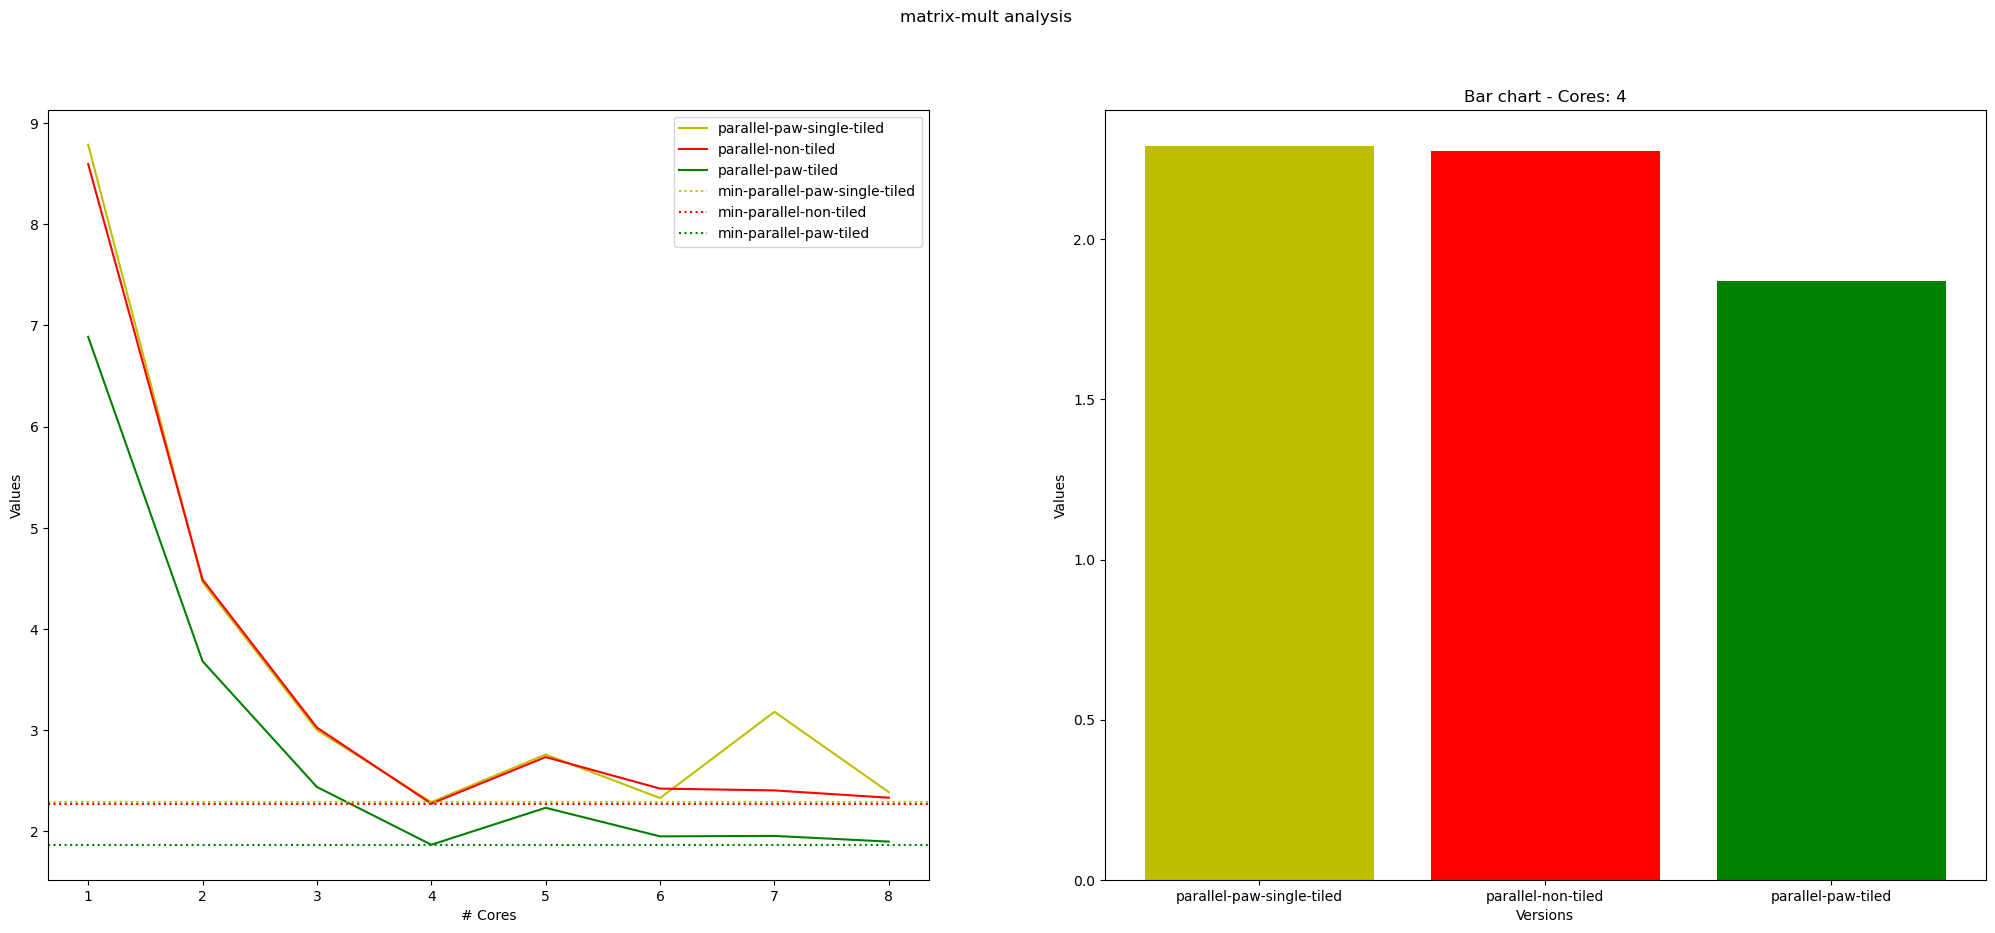

In [10]:
def plot_experiments(experiment_label, dataframe: pd.DataFrame, versions=[]):
    
    fig=plt.figure(figsize=(25, 10))
    
    plt.suptitle(experiment_label+' analysis')
    
    canva = fig.add_subplot(121)
    plot_lines(dataframe, versions, canva)
    
    canva2 = fig.add_subplot(122)
    plot_bars(dataframe, versions, canva2)
    
        
    
matrix_mult_speed_df = filter_by_experiment('matrix-mult','speed-up')
plot_experiments('matrix-mult', matrix_mult_speed_df)

In [11]:
def plot_bars_group(dataframe: pd.DataFrame, experiments=[]):
    if(len(experiments) == 0):
        experiments=get_unique(dataframe, 'experiment')
    
    return experiments

plot_bars_group(df)
    

array(['cache-misses', 'total-instructions', 'speed-up'], dtype=object)

# Matrix multiplication

## Analysis

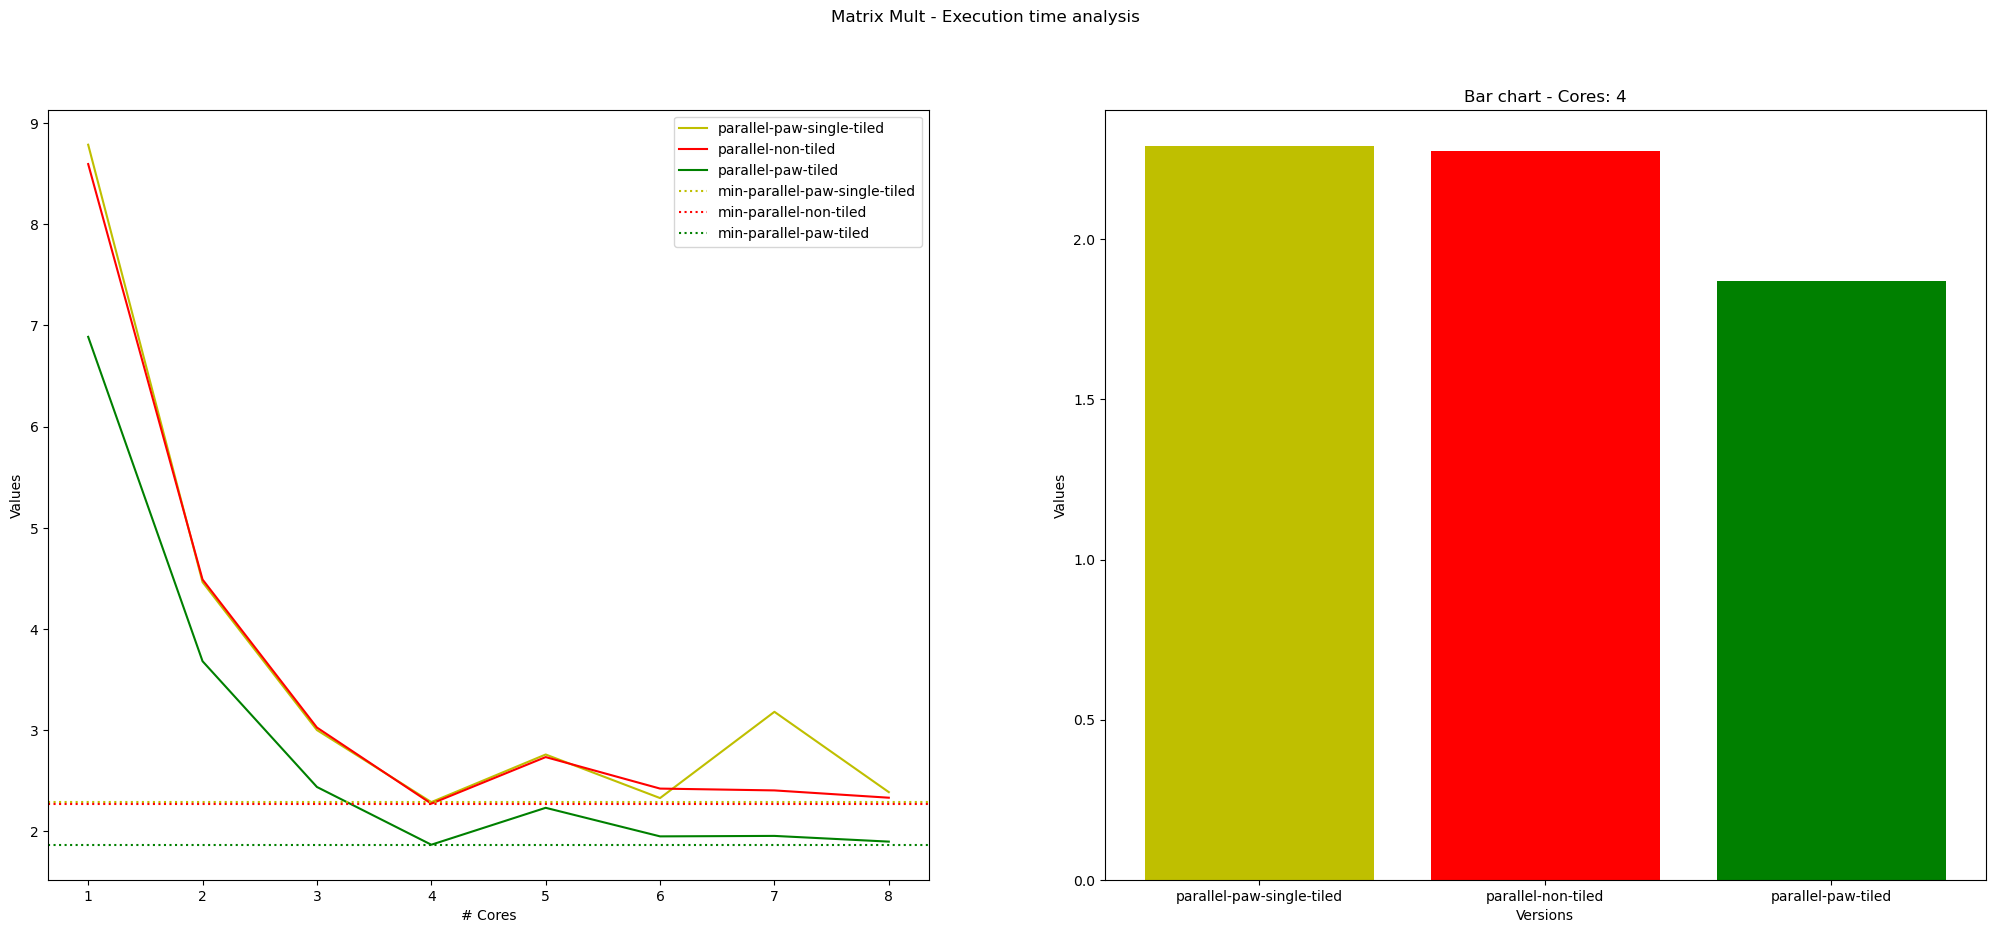

In [12]:
matrix_mult_experiments = filter_by_experiment('matrix-mult','speed-up')
plot_experiments('Matrix Mult - Execution time',matrix_mult_experiments)

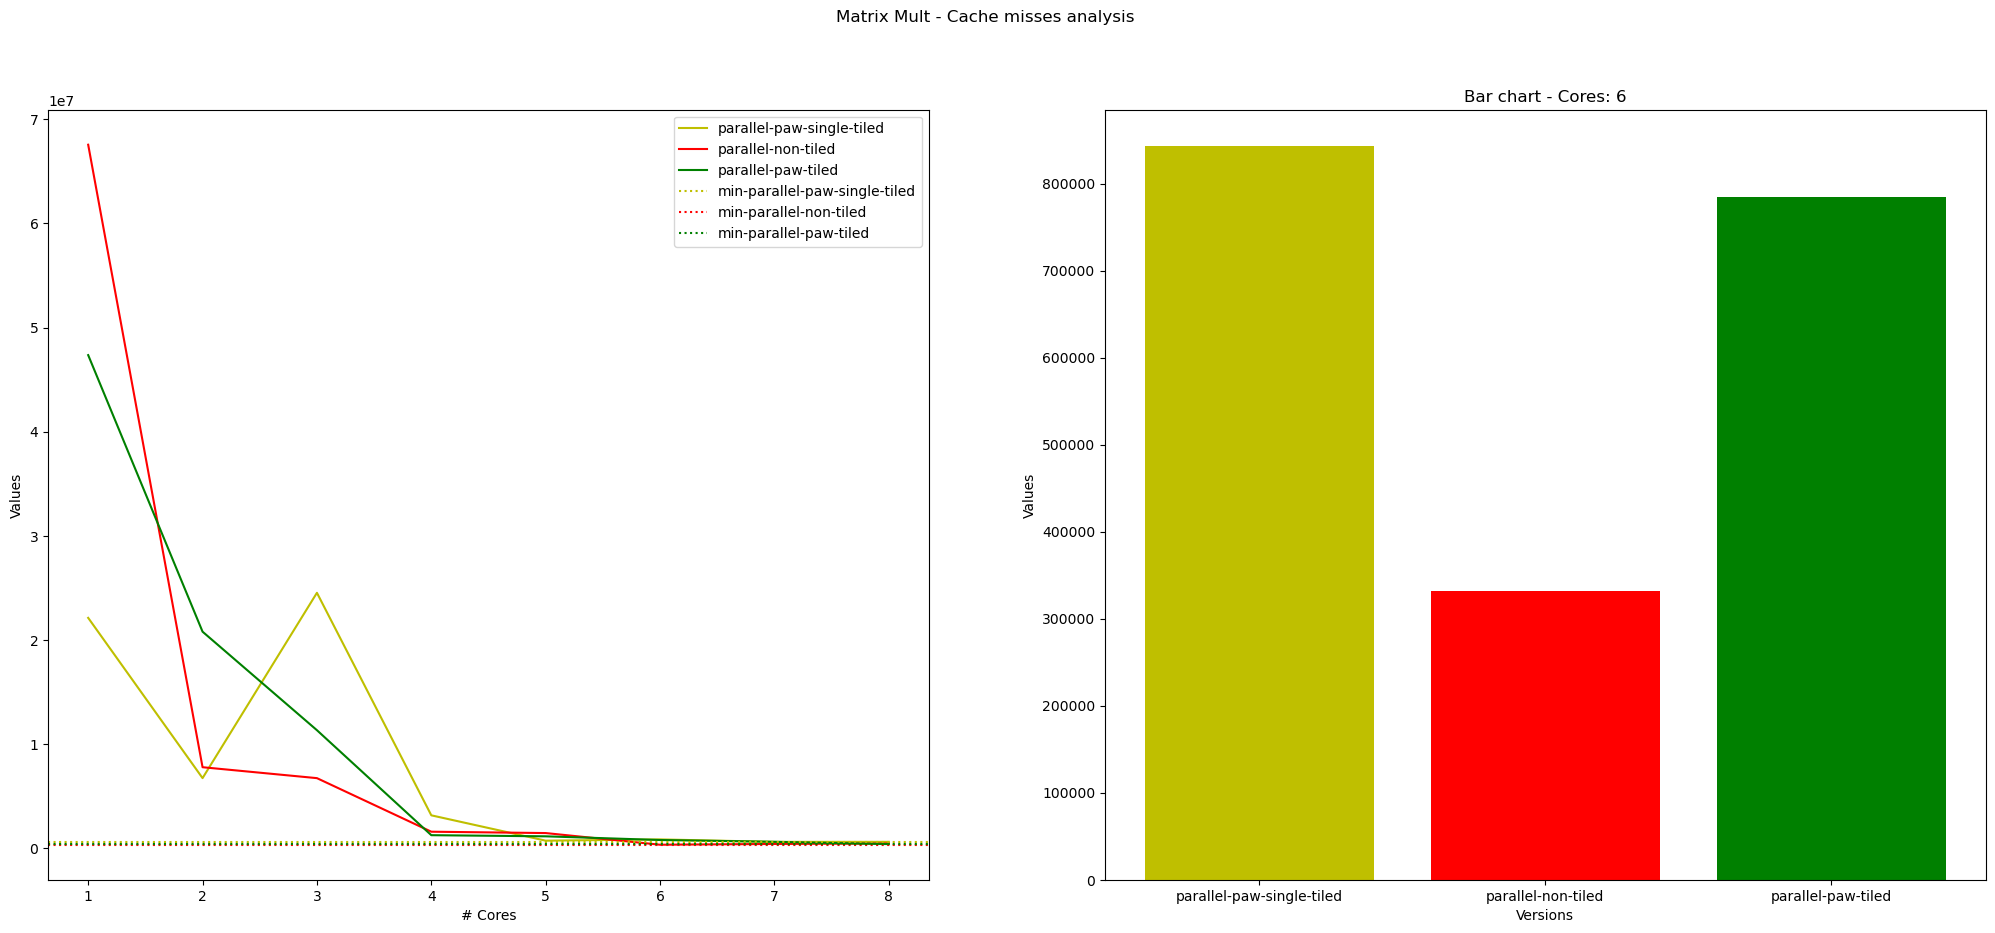

In [13]:
matrix_mult_experiments = filter_by_experiment('matrix-mult','cache-misses')
plot_experiments('Matrix Mult - Cache misses',matrix_mult_experiments)

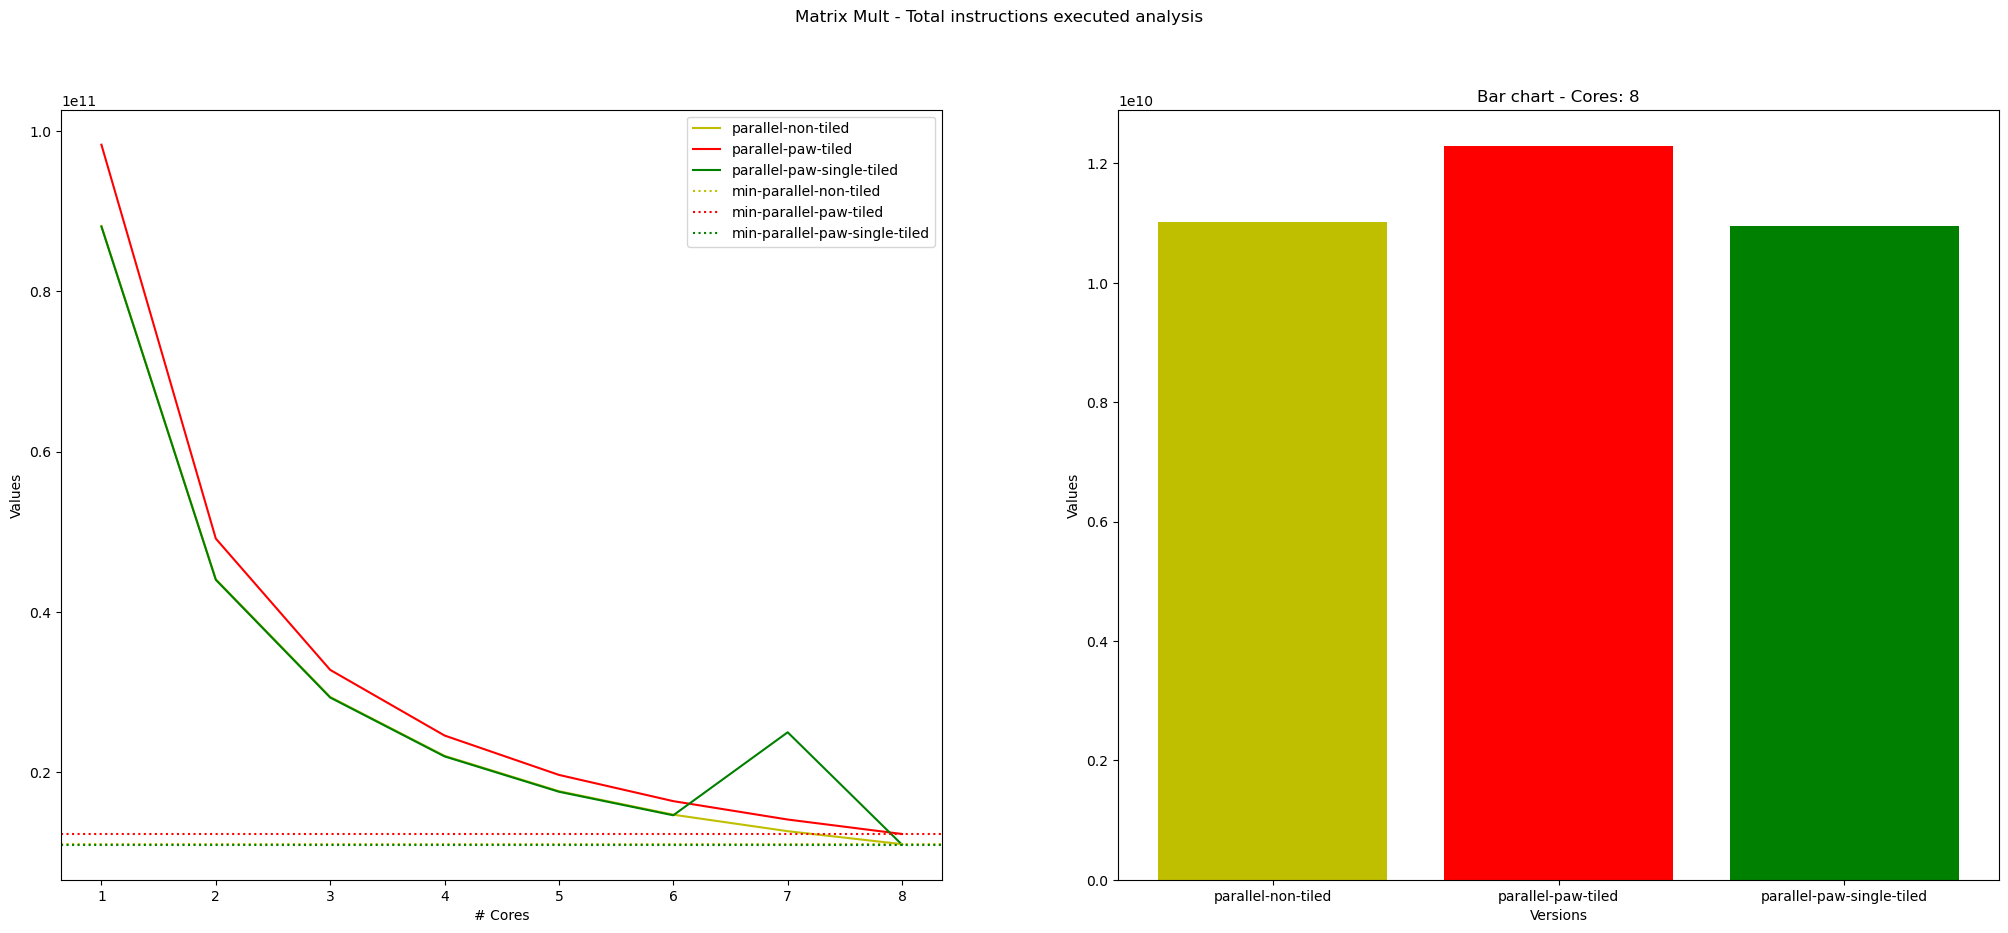

In [14]:
matrix_mult_experiments = filter_by_experiment('matrix-mult','total-instructions')

# versions=['parallel-non-tiled', 'parallel-paw-single-tiled']
plot_experiments('Matrix Mult - Total instructions executed',matrix_mult_experiments )

# Matrix-vector multiplication

## Analysis

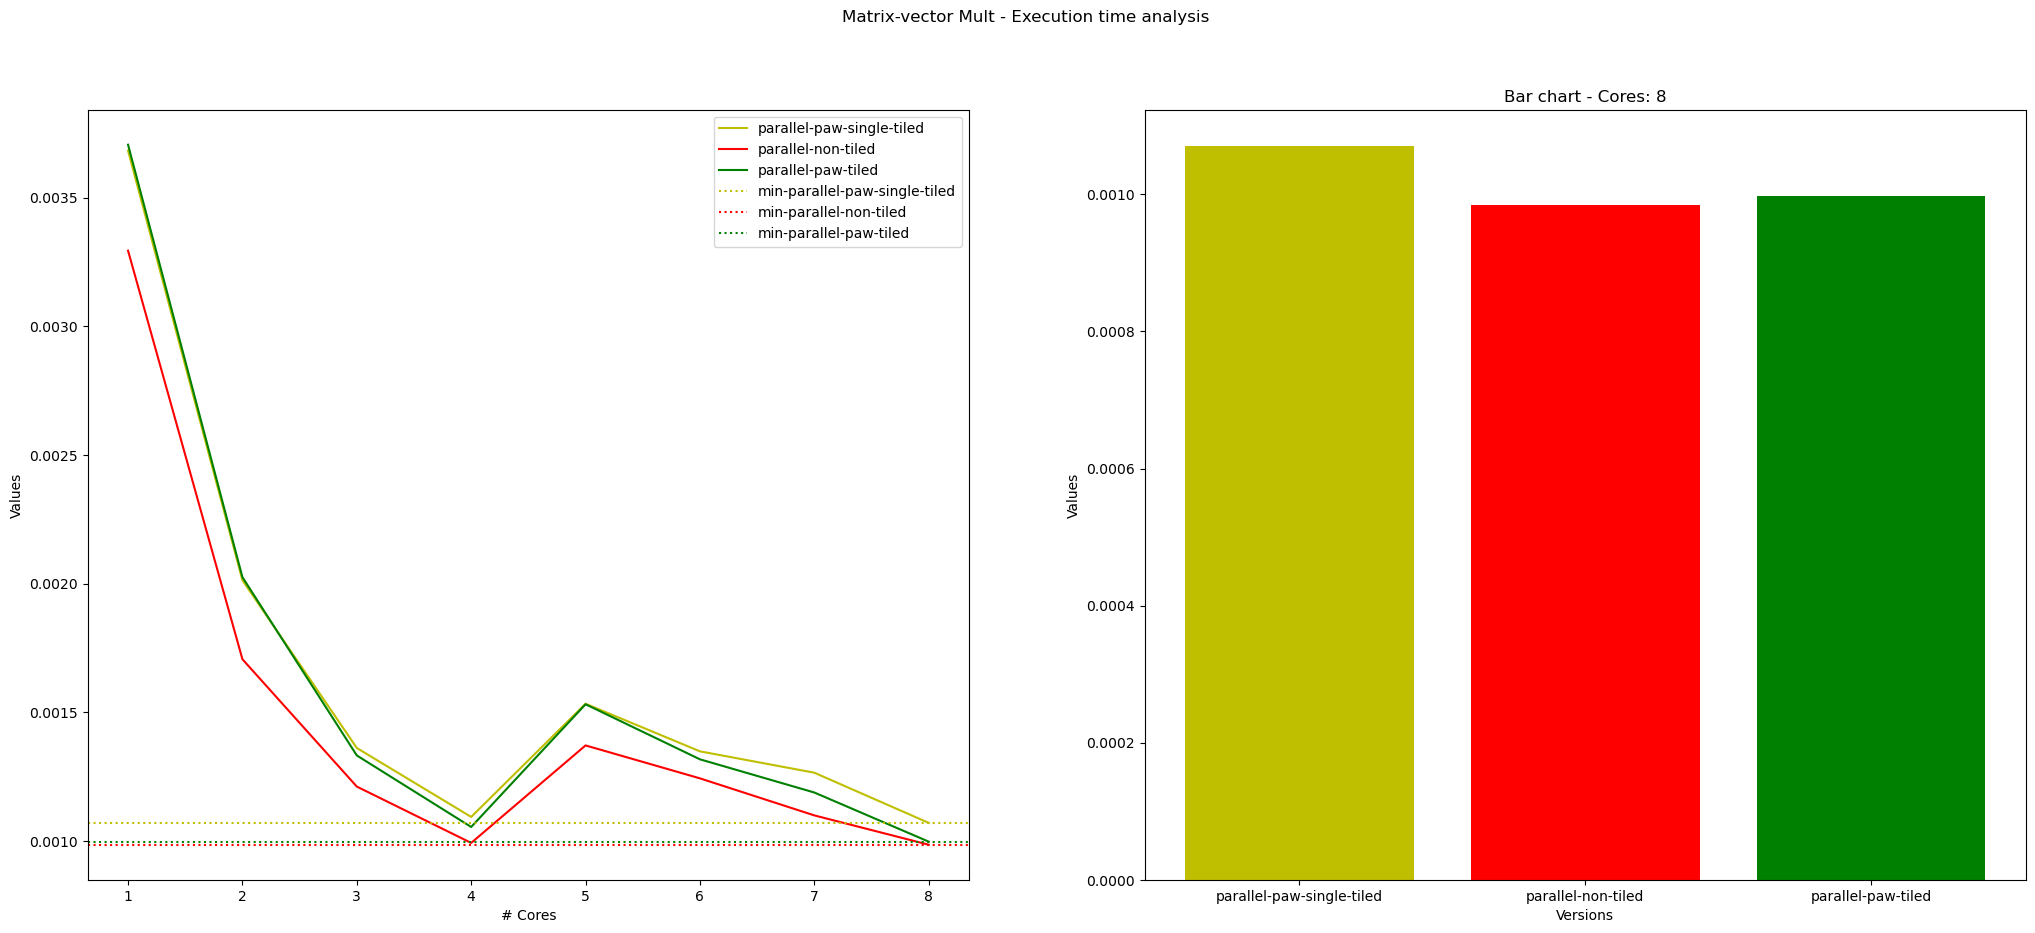

In [15]:
vector_mult_experiments = filter_by_experiment('vector-mult','speed-up')
plot_experiments('Matrix-vector Mult - Execution time',vector_mult_experiments)

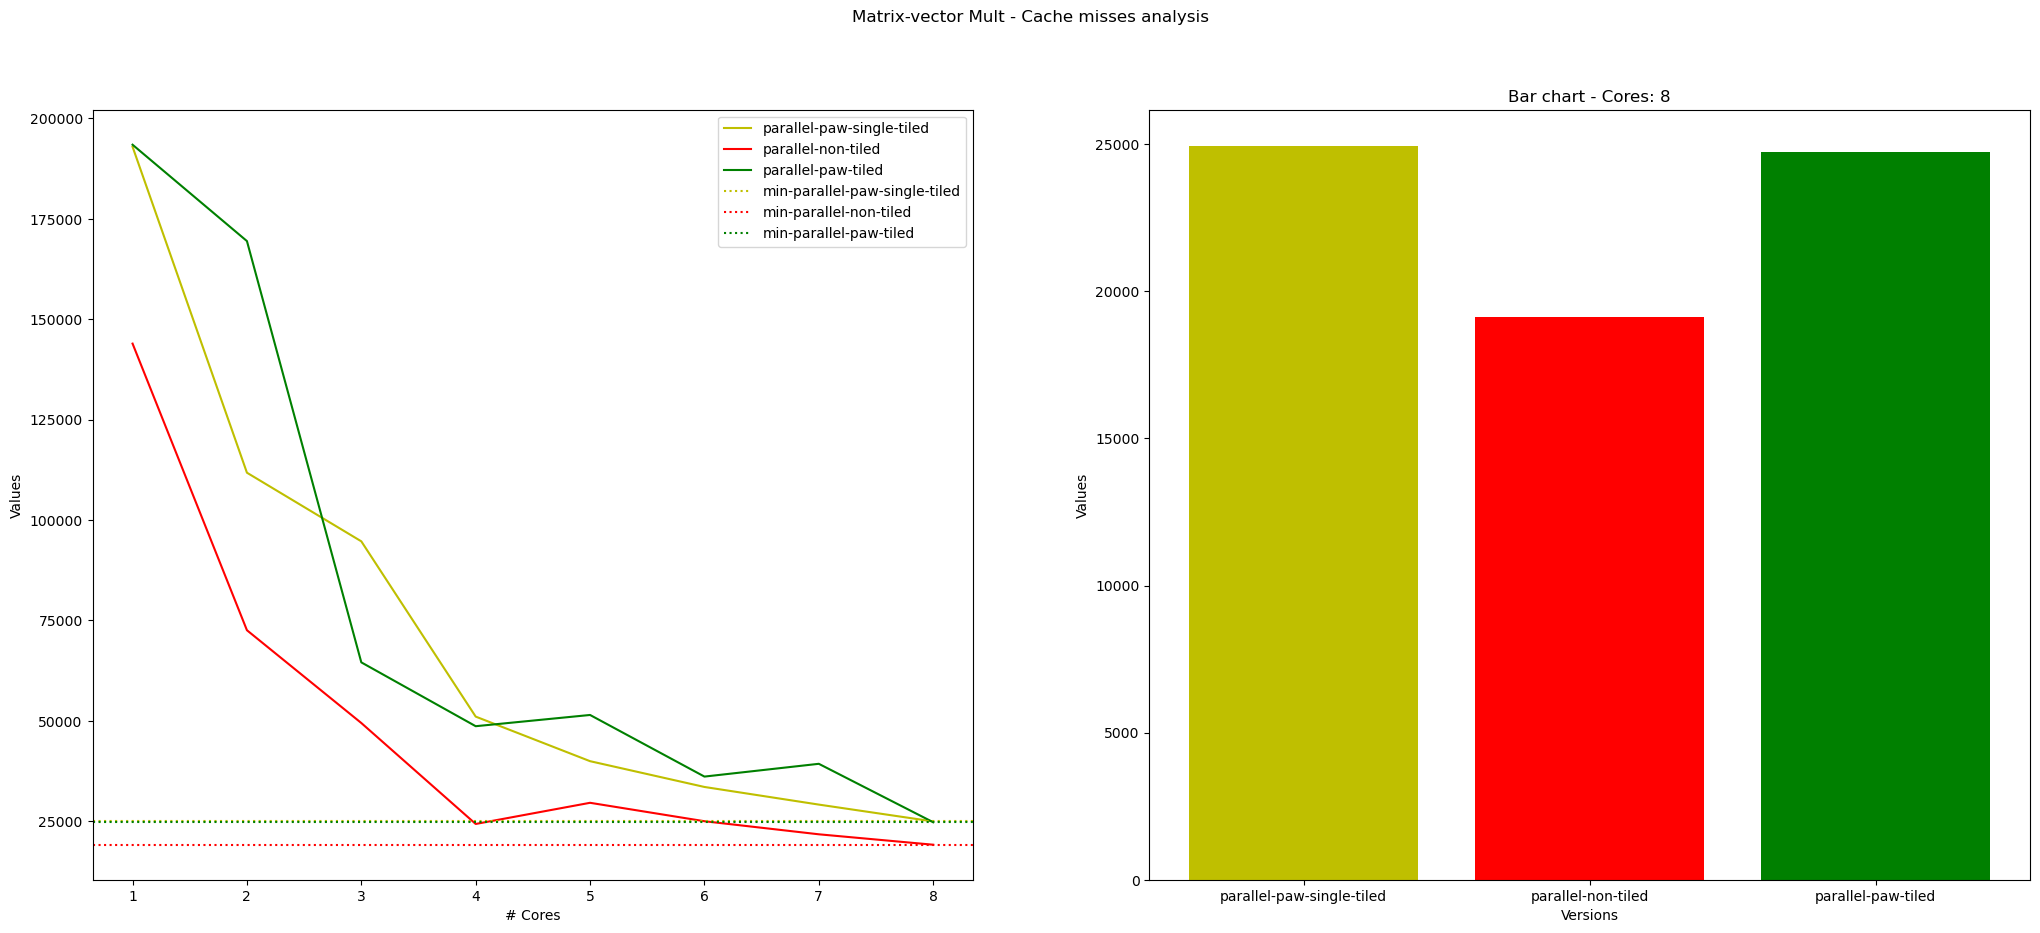

In [16]:
vector_mult_experiments = filter_by_experiment('vector-mult','cache-misses')
plot_experiments('Matrix-vector Mult - Cache misses',vector_mult_experiments)

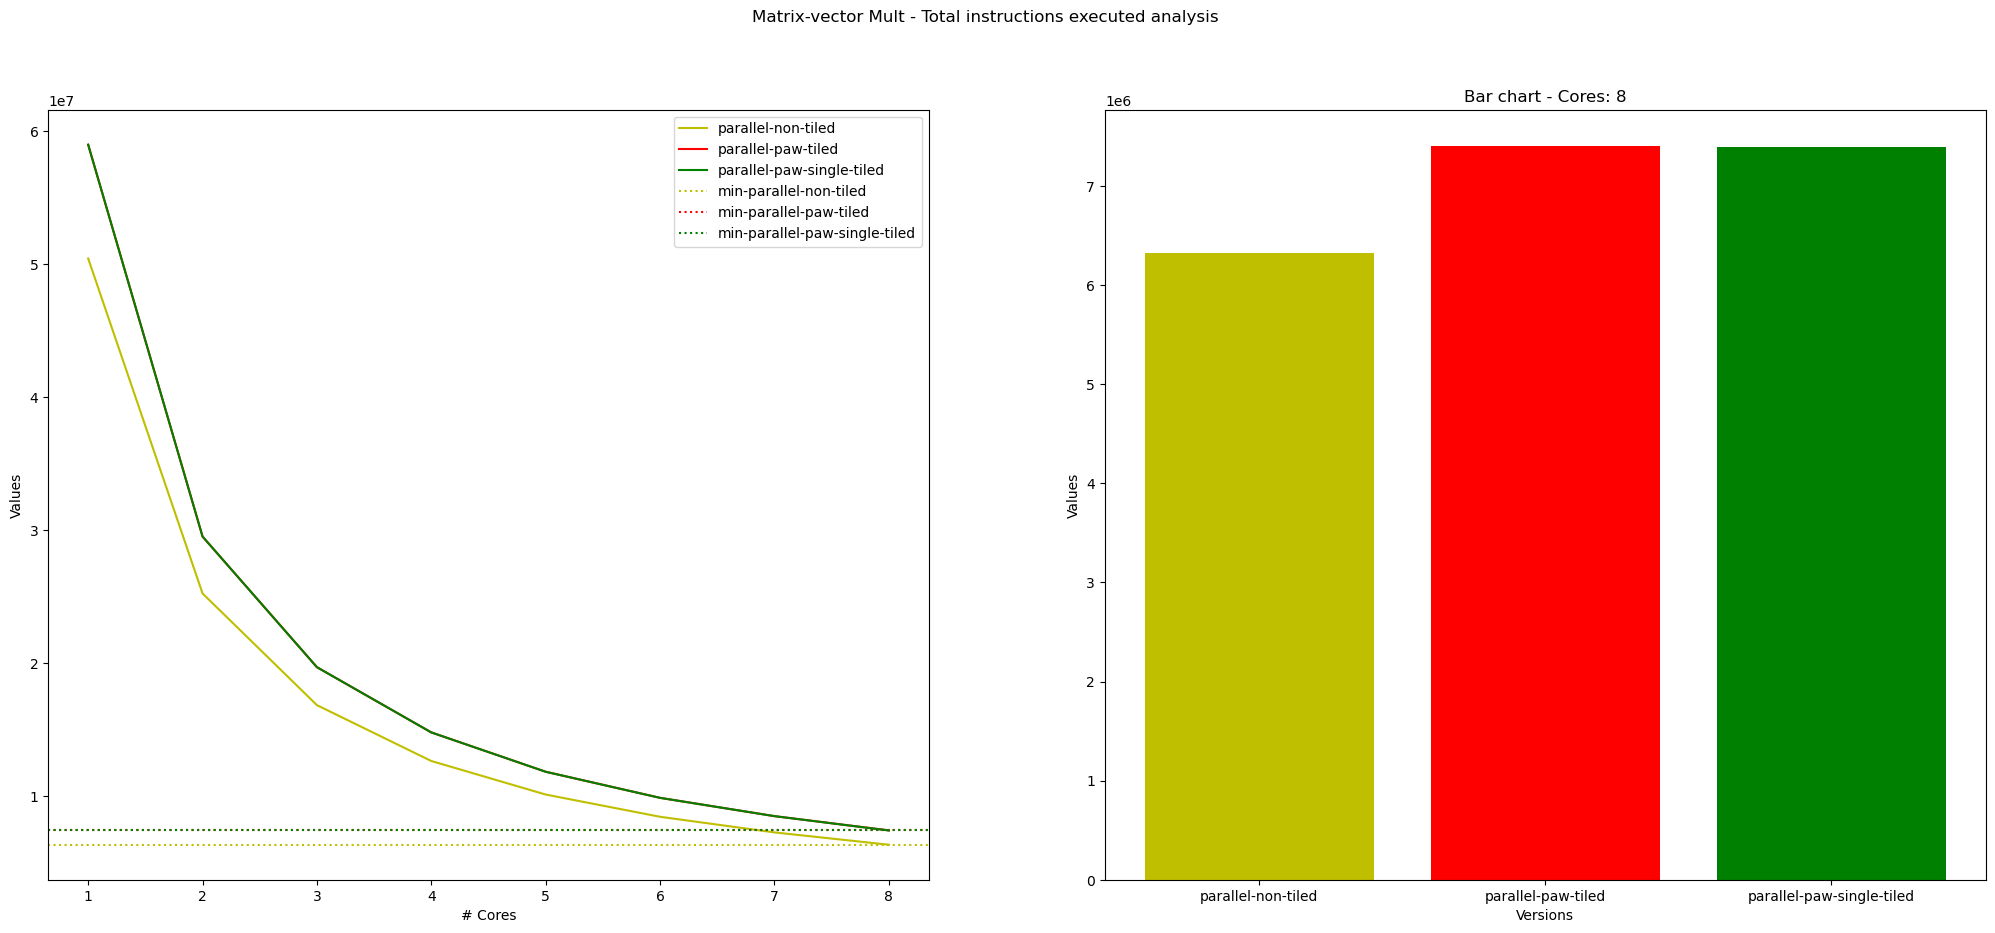

In [17]:
vector_mult_experiments = filter_by_experiment('vector-mult','total-instructions')
plot_experiments('Matrix-vector Mult - Total instructions executed',vector_mult_experiments)

# Jacobi

## Analysis

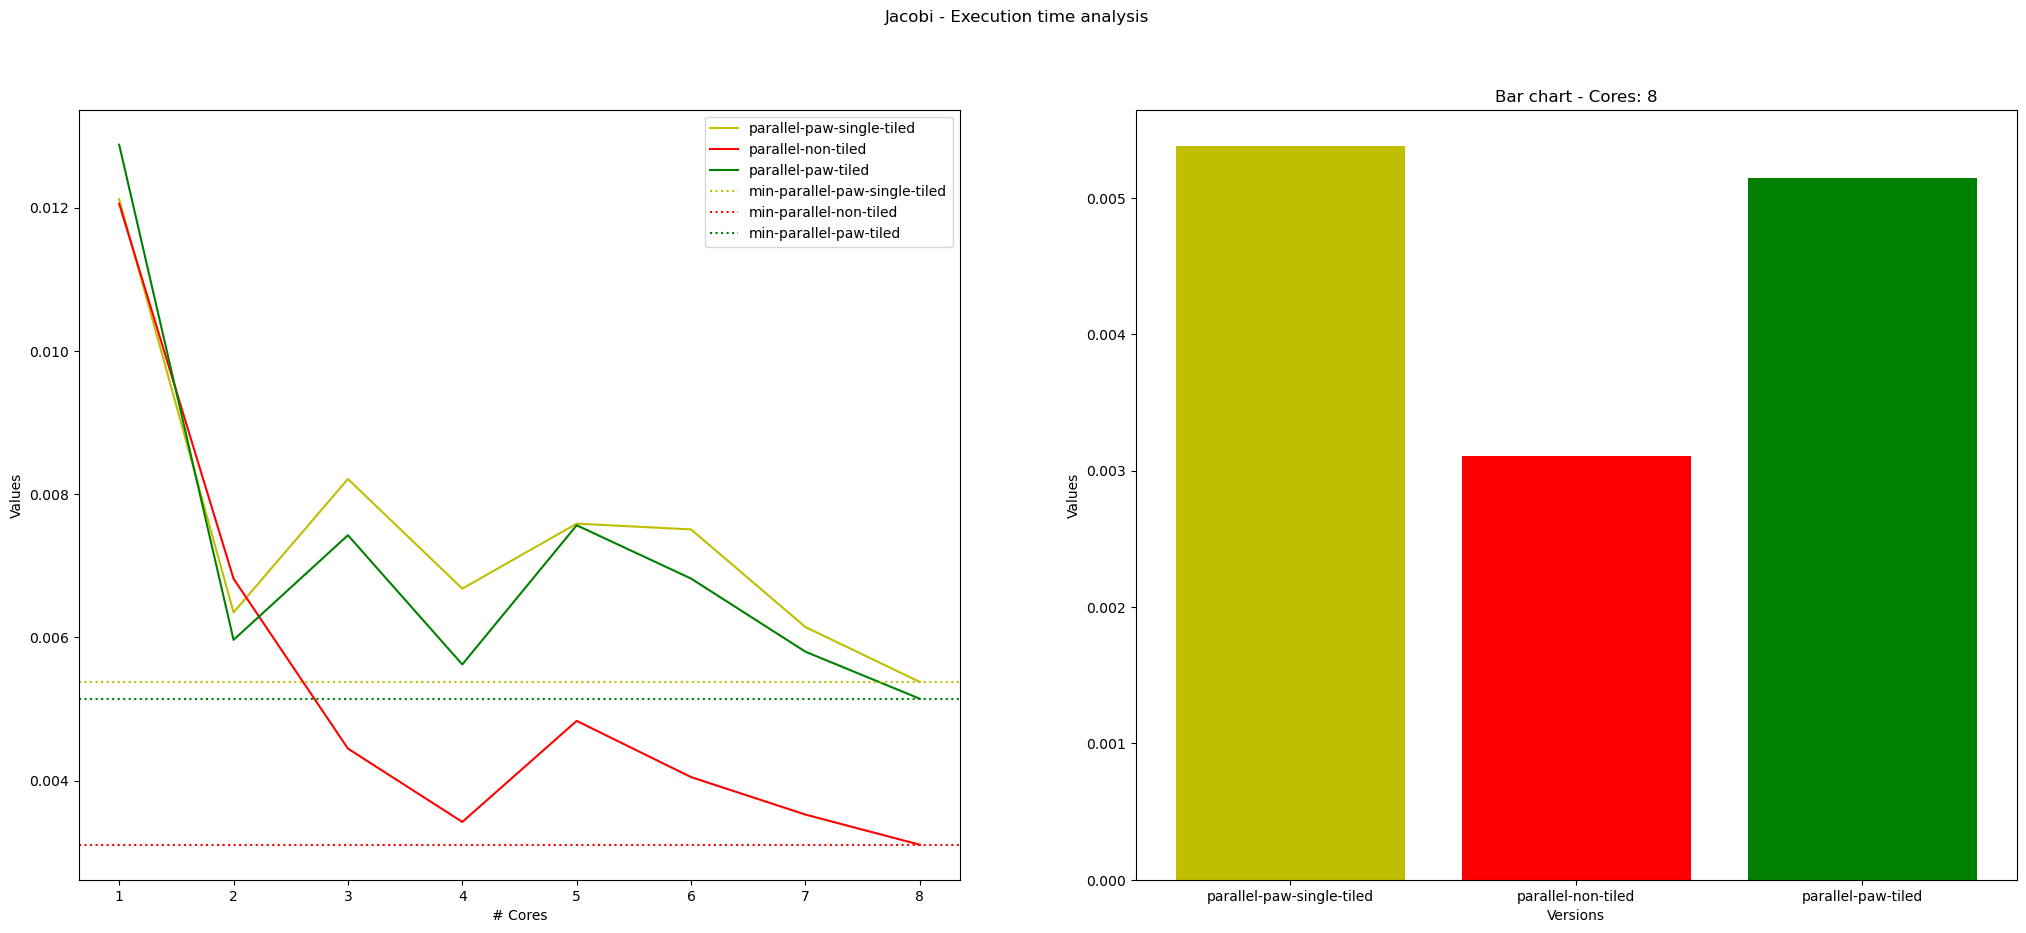

In [18]:
jacobi_experiments = filter_by_experiment('jacobi','speed-up')
plot_experiments('Jacobi - Execution time',jacobi_experiments)

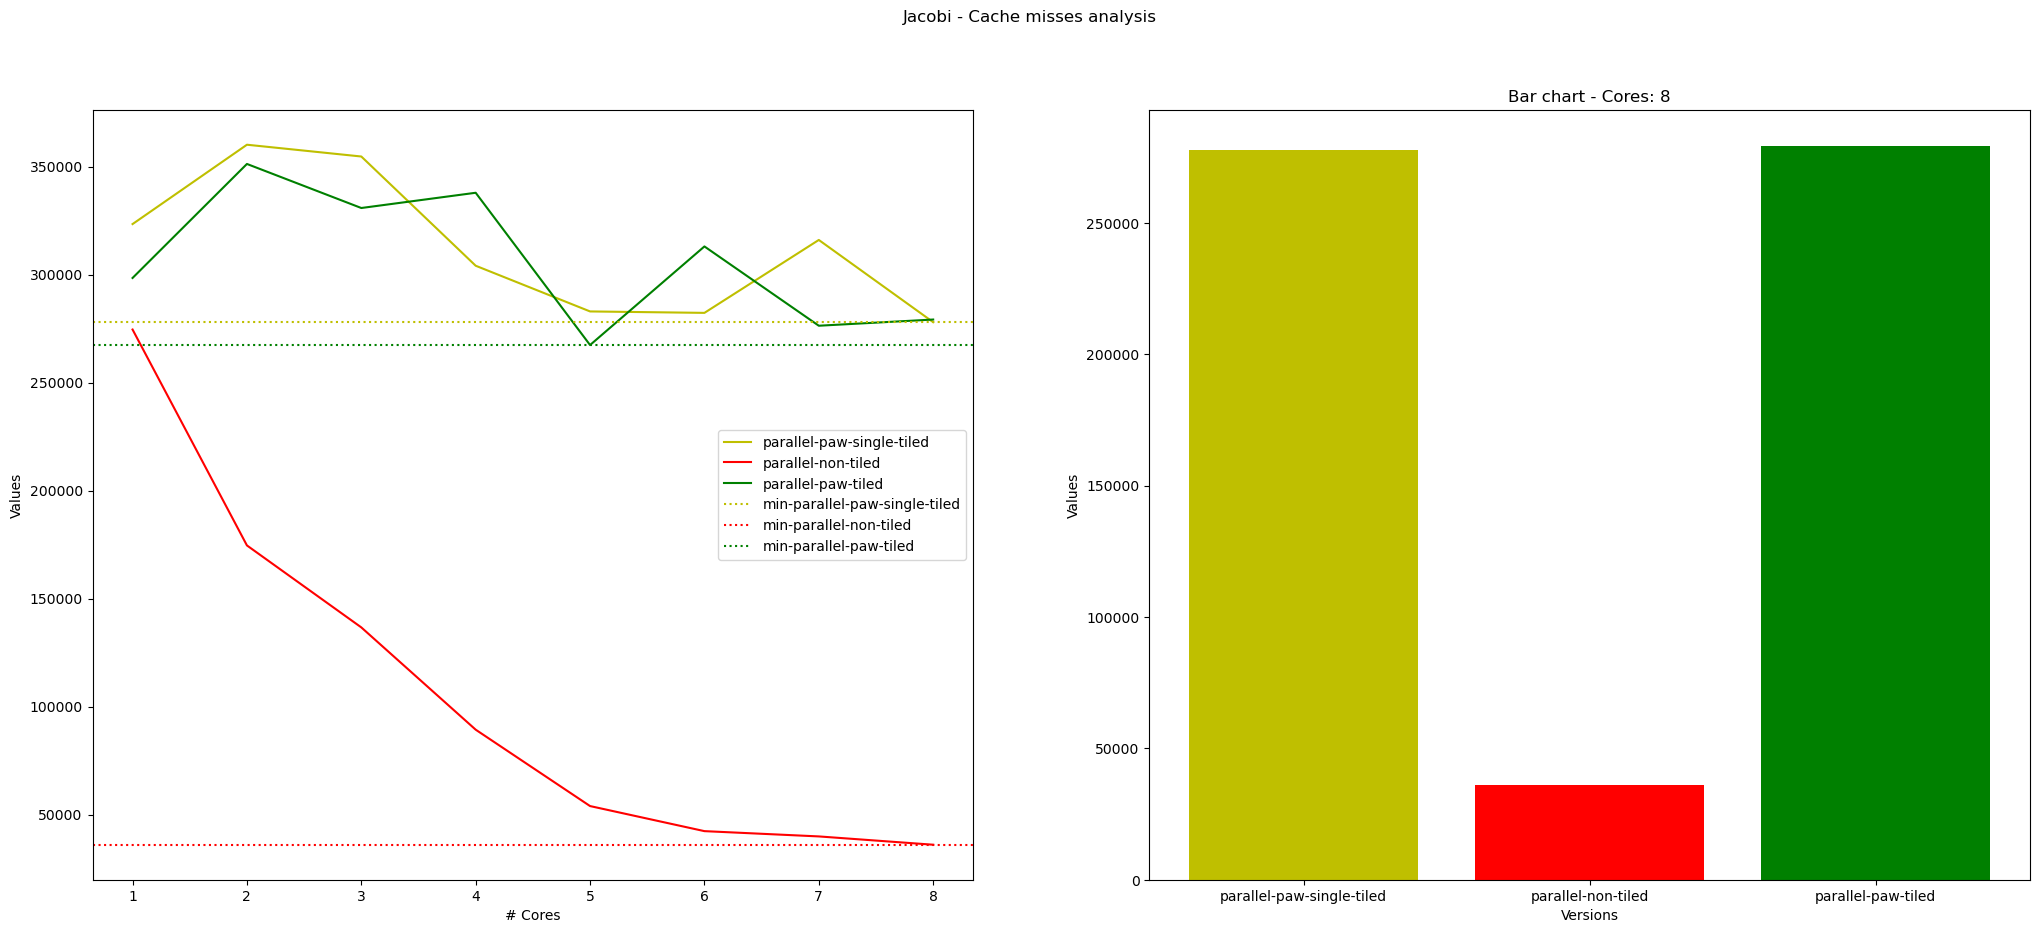

In [19]:
jacobi_experiments = filter_by_experiment('jacobi','cache-misses')
plot_experiments('Jacobi - Cache misses',jacobi_experiments)

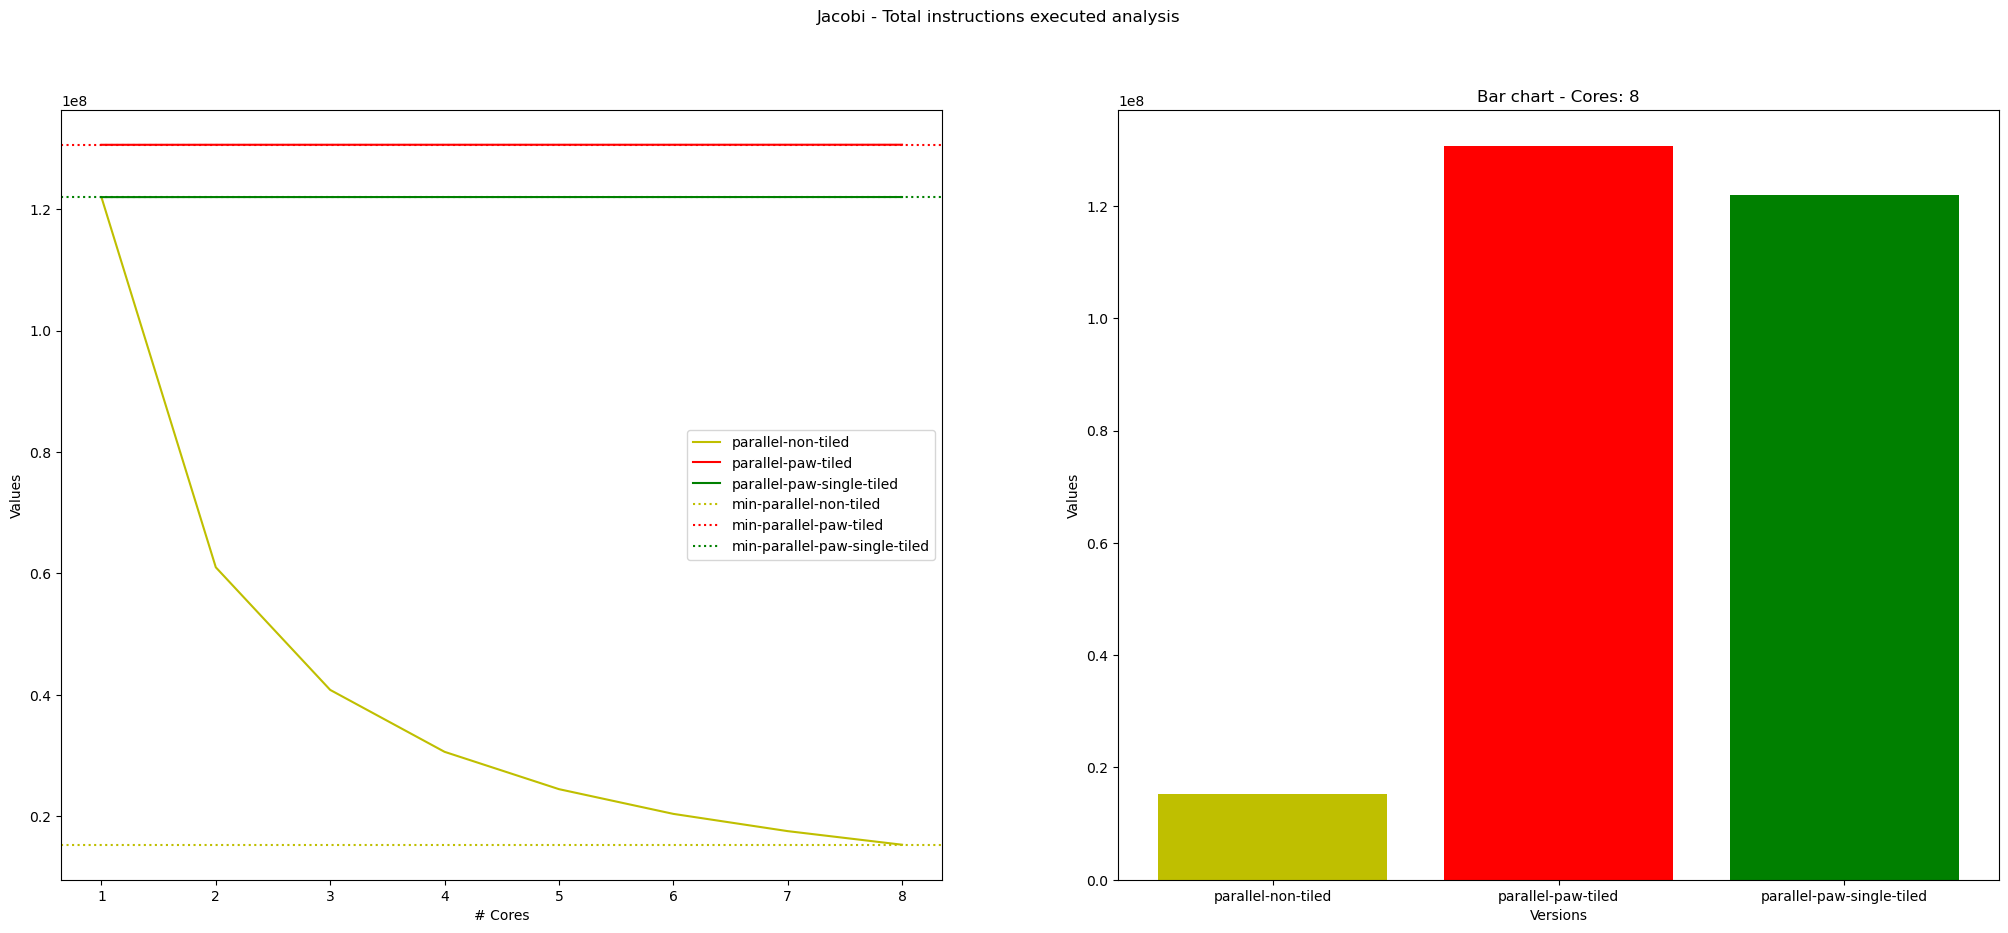

In [20]:
jacobi_experiments = filter_by_experiment('jacobi','total-instructions')
plot_experiments('Jacobi - Total instructions executed',jacobi_experiments)